In [2]:
#############################################################
# 1. Libraries

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import json
import glob
from tqdm.notebook import tqdm
import pickle
from collections import defaultdict
import time

from sklearn.model_selection import KFold, GroupKFold, StratifiedKFold
from sklearn.metrics import accuracy_score

from datetime import date, datetime
import plotly.graph_objs as go
import cv2
from scipy.spatial.distance import cdist

pd.options.display.max_colwidth = 100

import tensorflow as tf
tf.keras.backend.clear_session()

physical_devices = tf.config.list_physical_devices('GPU')

try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    print('Invalid device or cannot modify virtual devices once initialized.')

from tensorflow.keras import models, layers, regularizers, metrics, losses, optimizers, constraints
from tensorflow.keras.utils import Sequence

#############################################################

In [3]:
class Experiment(object):
    def __init__(self, **kwargs):
        self.__dict__ = kwargs

    def __repr__(self):
        return str(self.__dict__)

In [4]:
#################################################
# 1. Experiment & Global Variables & Paths

# Paths 

PATH_DATA = '../../01_Data/'
PATH_MODELS = '../../03_Models/'
PATH_PREDICTIONS = '../../04_Predictions/'
PATH_SUBMISSIONS = '../../05_Submissions/'

path_data_train = PATH_DATA + 'train/'
path_data_test = PATH_DATA + 'test/'
path_metadata = PATH_DATA + 'metadata/'

path_generated_data = PATH_DATA + 'GeneratedData/'
path_generated_data_train = PATH_DATA + 'GeneratedData/v0.2/train/'
path_generated_data_test = PATH_DATA + 'GeneratedData/v0.2/test/'

VERSION = '007'

DICT_FLOOR_MAP = {'1F' :  0, '2F' : 1, '3F' : 2, '4F' : 3, '5F' : 4, 
                     '6F' : 5, '7F' : 6, '8F' : 7, '9F' : 8,
                     'B'  : -1, 'B1' : -1, 'B2' : -2, 'B3' : -3, 
                     'BF' : -1, 'BM' : -1, 
                     'F1' : 0, 'F2' : 1, 'F3' : 2, 'F4' : 3, 'F5' : 4, 
                     'F6' : 5, 'F7' : 6, 'F8' : 7, 'F9' : 8, 'F10': 9,
                     'L1' : 0, 'L2' : 1, 'L3' : 2, 'L4' : 3, 'L5' : 4, 
                     'L6' : 5, 'L7' : 6, 'L8' : 7, 'L9' : 8, 'L10': 9, 
                     'L11': 10,
                     'G'  : 0, 'LG1': 0, 'LG2': 1, 'LM' : 0, 'M'  : 0, 
                     'P1' : 0, 'P2' : 1,}


#################################################

In [5]:
#################################################
# 2. Load Data

model_name_positions = 'trf_enc_dec_v0.13' #'trf_enc_dec_v0.8.4'
model_name_floors = 'floor_model_v0.4'

# Positions
# with open(f'{PATH_PREDICTIONS}{model_name_positions}/predictions.pkl', 'rb') as f:
#     dict_predictions_positions = pickle.load(f) 
    
with open(f'{PATH_PREDICTIONS}{model_name_positions}/val_predictions.pkl', 'rb') as f:
    dict_val_predictions_positions = pickle.load(f) 
    
# Floors
# with open(f'{PATH_PREDICTIONS}{model_name_floors}/predictions.pkl', 'rb') as f:
#     dict_predictions_floors = pickle.load(f) 
    
# Load experiment
with open(f'{path_generated_data}Experiment_{VERSION}.pkl', 'rb') as f:
    experiment = pickle.load(f)
    
dict_all_sites = experiment.dict_all_sites

# Load dict_training_waypoints
with open(f'{path_generated_data}dict_training_waypoints_005.pkl', 'rb') as f:
    dict_training_waypoints = pickle.load(f)

# Build floor dictionary
df_floor = pd.read_csv(PATH_PREDICTIONS + model_name_floors + '/submission.csv')
df_floor = df_floor[['site_path_timestamp', 'floor']]

df_floor['site'] = df_floor['site_path_timestamp'].\
                                              apply(lambda x: dict_all_sites[x.split('_')[0]])
df_floor['path'] = df_floor['site_path_timestamp'].\
                                apply(lambda x: x.split('_')[1])
dict_floors_test = {}
for i, row in df_floor.iterrows():
    dict_floors_test[row['path']] = row['floor']
    
list_train_paths = glob.glob(path_generated_data_train + '*')
list_train_traces = [trace.split('\\')[-1] for trace in list_train_paths]
dict_train_traces_paths = {trace : path for trace, path in zip(list_train_traces, list_train_paths)}
dict_training_floor = {}
for trace in tqdm(list_train_traces):
    path = dict_train_traces_paths[trace]
    data = np.load(f'{path}/waypoint_predict.npy', allow_pickle=True).astype(np.float32)
    floor = data[:, 0][0]
    dict_training_floor[trace] = floor
    

#Embedding dims

EMB_SITE_DIM = len(experiment.dict_all_sites)
EMB_UUID_DIM = len(experiment.dict_unique_uuid)
EMB_BSSID_DIM = len(experiment.dict_unique_bssid)
EMB_SSID_DIM = len(experiment.dict_unique_ssid)
NUM_FLOORS = len(experiment.list_floors_train_filtered)


#################################################

In [6]:
#################################################
# 3. Functions

def visualizeTrajectory(y_true_trajectory, y_pred_trajectory, floor_plan_filename, width_meter, height_meter,
                        title=None, mode='lines + markers + text', show=False):

    fig = go.Figure()

    # add trajectory
    size_list = [5] * y_true_trajectory.shape[0]
    size_list[0] = 10
    size_list[-1] = 10

    color_list = ['rgba(4, 174, 4, 0.5)'] * y_true_trajectory.shape[0]
    #color_list[0] = 'rgba(12, 5, 235, 1)'
    #color_list[-1] = 'rgba(235, 5, 5, 1)'

    position_count = {}
    text_list = []
    for i in range(y_true_trajectory.shape[0]):
        if str(y_true_trajectory[i]) in position_count:
            position_count[str(y_true_trajectory[i])] += 1
        else:
            position_count[str(y_true_trajectory[i])] = 0
        text_list.append('        ' * position_count[str(y_true_trajectory[i])] + f'{i}')
    text_list[0] = 'Start 0'
    text_list[-1] = f'End {y_true_trajectory.shape[0] - 1}'
    
    if y_true_trajectory is not None:
        fig.add_trace(
            go.Scattergl(
                x=y_true_trajectory[:, 0],
                y=y_true_trajectory[:, 1],
                mode=mode,
                marker=dict(size=size_list, color=color_list),
                line=dict(shape='linear', color='red', width=3, dash='dash'),
                text=text_list,
                textposition="top center",
                name='true',
            ))
    
    if y_pred_trajectory is not None:
        fig.add_trace(
            go.Scattergl(
                x=y_pred_trajectory[:, 0],
                y=y_pred_trajectory[:, 1],
                mode=mode,
                marker=dict(size=size_list, color=color_list),
                line=dict(shape='linear', color='blue', width=3, dash='dash'),
                text=text_list,
                textposition="top center",
                name='pred',
            ))

    # add floor plan
    floor_plan = Image.open(floor_plan_filename)
    fig.update_layout(images=[
        go.layout.Image(
            source=floor_plan,
            xref="x",
            yref="y",
            x=0,
            y=height_meter,
            sizex=width_meter,
            sizey=height_meter,
            sizing="contain",
            opacity=1,
            layer="below",
        )
    ])

    # configure
    fig.update_xaxes(autorange=False, range=[0, width_meter])
    fig.update_yaxes(autorange=False, range=[0, height_meter], scaleanchor="x", scaleratio=1)
    fig.update_layout(
        title=go.layout.Title(
            text=title or "No title.",
            xref="paper",
            x=0,
        ),
        autosize=True,
        width=600,
        height=600 * height_meter / width_meter,
        template="plotly_white",
    )

    if show:
        fig.show()

    return fig


def plotTrajectory(site, floor, y_true, y_pred):
    
    with open(f"{PATH_DATA}metadata/{site}/{floor}/floor_info.json") as f:
        train_floor_info = json.load(f)

    return visualizeTrajectory(
        y_true,
        y_pred,
        f"{PATH_DATA}metadata/{site}/{floor}/floor_image.png",
        train_floor_info["map_info"]["width"], 
        train_floor_info["map_info"]["height"],
        f"Visualization of {path}"
    )

def closestPoint(point, list_points):
    return list_points[cdist([point], list_points).argmin()]


#################################################

In [7]:
#################################################
# Get dictionary with all site and traces + Get y_true

# 0. dict trace, site and floor
dict_site_floor_traces = {}
list_site_floor_traces = glob.glob(PATH_DATA  + 'train/' + '/*/*/*.txt')
for file in tqdm(list_site_floor_traces):
    list_file = file.split('\\')
    site = list_file[1]
    floor = list_file[2]
    trace = list_file[-1].replace('.txt', '')
    dict_site_floor_traces[trace] = (site, floor)
    
# 1. Get ground truth - trace index
dict_train_true_positions = {}
for trace in tqdm(dict_train_traces_paths):
    site, floor = dict_site_floor_traces[trace]
    labels = np.load(f'{dict_train_traces_paths[trace]}/waypoint_predict.npy', allow_pickle=True).astype(np.float32)
    dict_train_true_positions[trace] = {
        'site' : site,
        'floor' : floor,
        'label' : labels[:, 1:]
    }
    
    
#################################################

## Post-processing


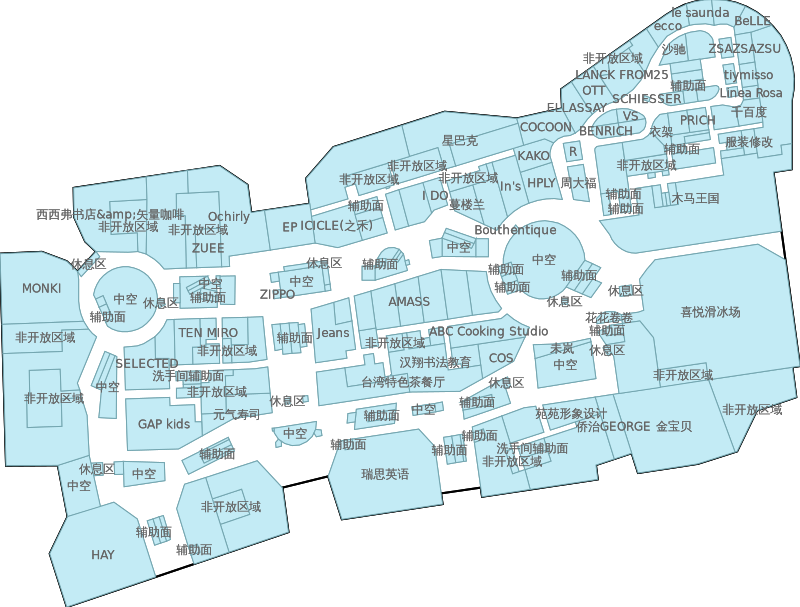

In [28]:
#################################################
# Raw predictions

trace = np.random.choice(list(dict_val_predictions_positions.keys())) #'5d03947de99446000843c202' #
site, floor = dict_site_floor_traces[trace] #'5cd56c18e2acfd2d33b6c321', 'L2'
# trace = '5d03947de99446000843c202'
# site, floor = '5cd56c18e2acfd2d33b6c321', 'L2'

plotTrajectory(site, floor, 
               y_true=dict_train_true_positions[trace]['label'], 
               y_pred=dict_val_predictions_positions[trace]['predictions'] * 100)

#################################################

In [33]:
#################################################
# Get closest train position

dict_train_points = {site : {} for site in list(dict_all_sites)}
for i, trace in enumerate(tqdm(dict_train_true_positions)):
    site, floor = dict_train_true_positions[trace]['site'], dict_train_true_positions[trace]['floor']
    if floor not in dict_train_points[site]:
        dict_train_points[site][floor] = []
    for point in dict_train_true_positions[trace]['label']:
        dict_train_points[site][floor].append((point[0]/100., point[1]/100.))


dict_val_predictions_positions_matched = {}
for trace in tqdm(dict_val_predictions_positions):
    site, floor = dict_site_floor_traces[trace]
    list_matched_points = []
    for point in dict_val_predictions_positions[trace]['predictions']:
        matched_points = closestPoint(point, dict_train_points[site][floor])
        list_matched_points.append((matched_points[0], matched_points[1]))
    dict_val_predictions_positions_matched[trace] = {
        'site' : site,
        'floor' : floor,
        'prediction' : np.asarray(list_matched_points)
    }
    
# Apply a threshold

threshold = 15
dict_matched_prediction_filtered = {}
for trace in tqdm(dict_val_predictions_positions):
    site, floor = dict_val_predictions_positions_matched[trace]['site'], dict_val_predictions_positions_matched[trace]['floor']
    dist = np.sqrt(np.power(dict_val_predictions_positions[trace]['predictions'][:, 0] - dict_val_predictions_positions_matched[trace]['prediction'][:, 0], 2) + \
                   np.power(dict_val_predictions_positions[trace]['predictions'][:, 1] - dict_val_predictions_positions_matched[trace]['prediction'][:, 1], 2)) * 100
    
    x = np.where(dist < threshold, 
             dict_val_predictions_positions_matched[trace]['prediction'][:, 0], 
             dict_val_predictions_positions[trace]['predictions'][:, 0])
    y = np.where(dist < threshold, 
             dict_val_predictions_positions_matched[trace]['prediction'][:, 1], 
             dict_val_predictions_positions[trace]['predictions'][:, 1])

    x_y = np.concatenate([np.expand_dims(x, 1), np.expand_dims(y, 1)], axis=-1)
    dict_matched_prediction_filtered[trace] = {
        'site' : site,
        'floor' : floor,
        'prediction' : x_y
    }
        
#################################################


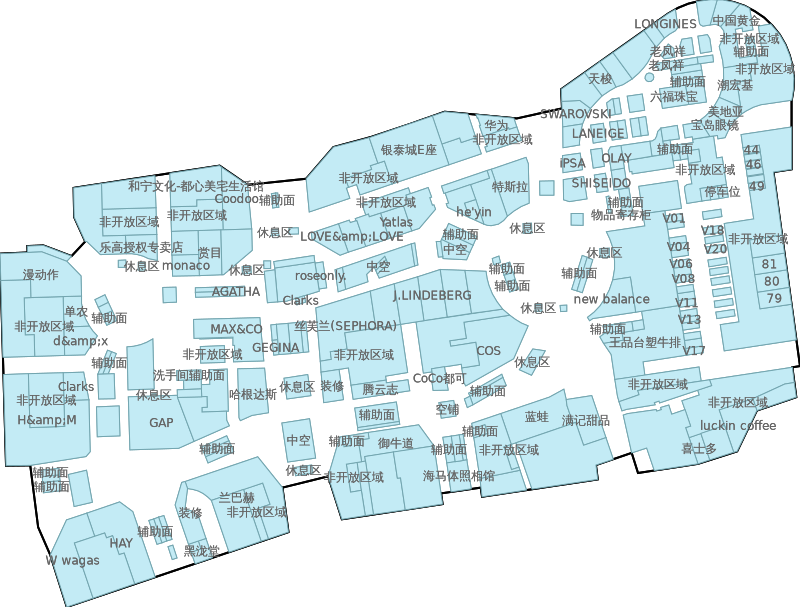

In [34]:
#################################################
# Closest Train prediction

trace = np.random.choice(list(dict_val_predictions_positions.keys())) #'5d03947de99446000843c202' #
site, floor = dict_site_floor_traces[trace] #'5cd56c18e2acfd2d33b6c321', 'L2'

# trace = '5d03947de99446000843c202'
# site, floor = '5cd56c18e2acfd2d33b6c321', 'L2'

plotTrajectory(site, floor, 
               y_true=dict_train_true_positions[trace]['label'], 
               y_pred=dict_val_predictions_positions_matched[trace]['prediction'] * 100)

#################################################


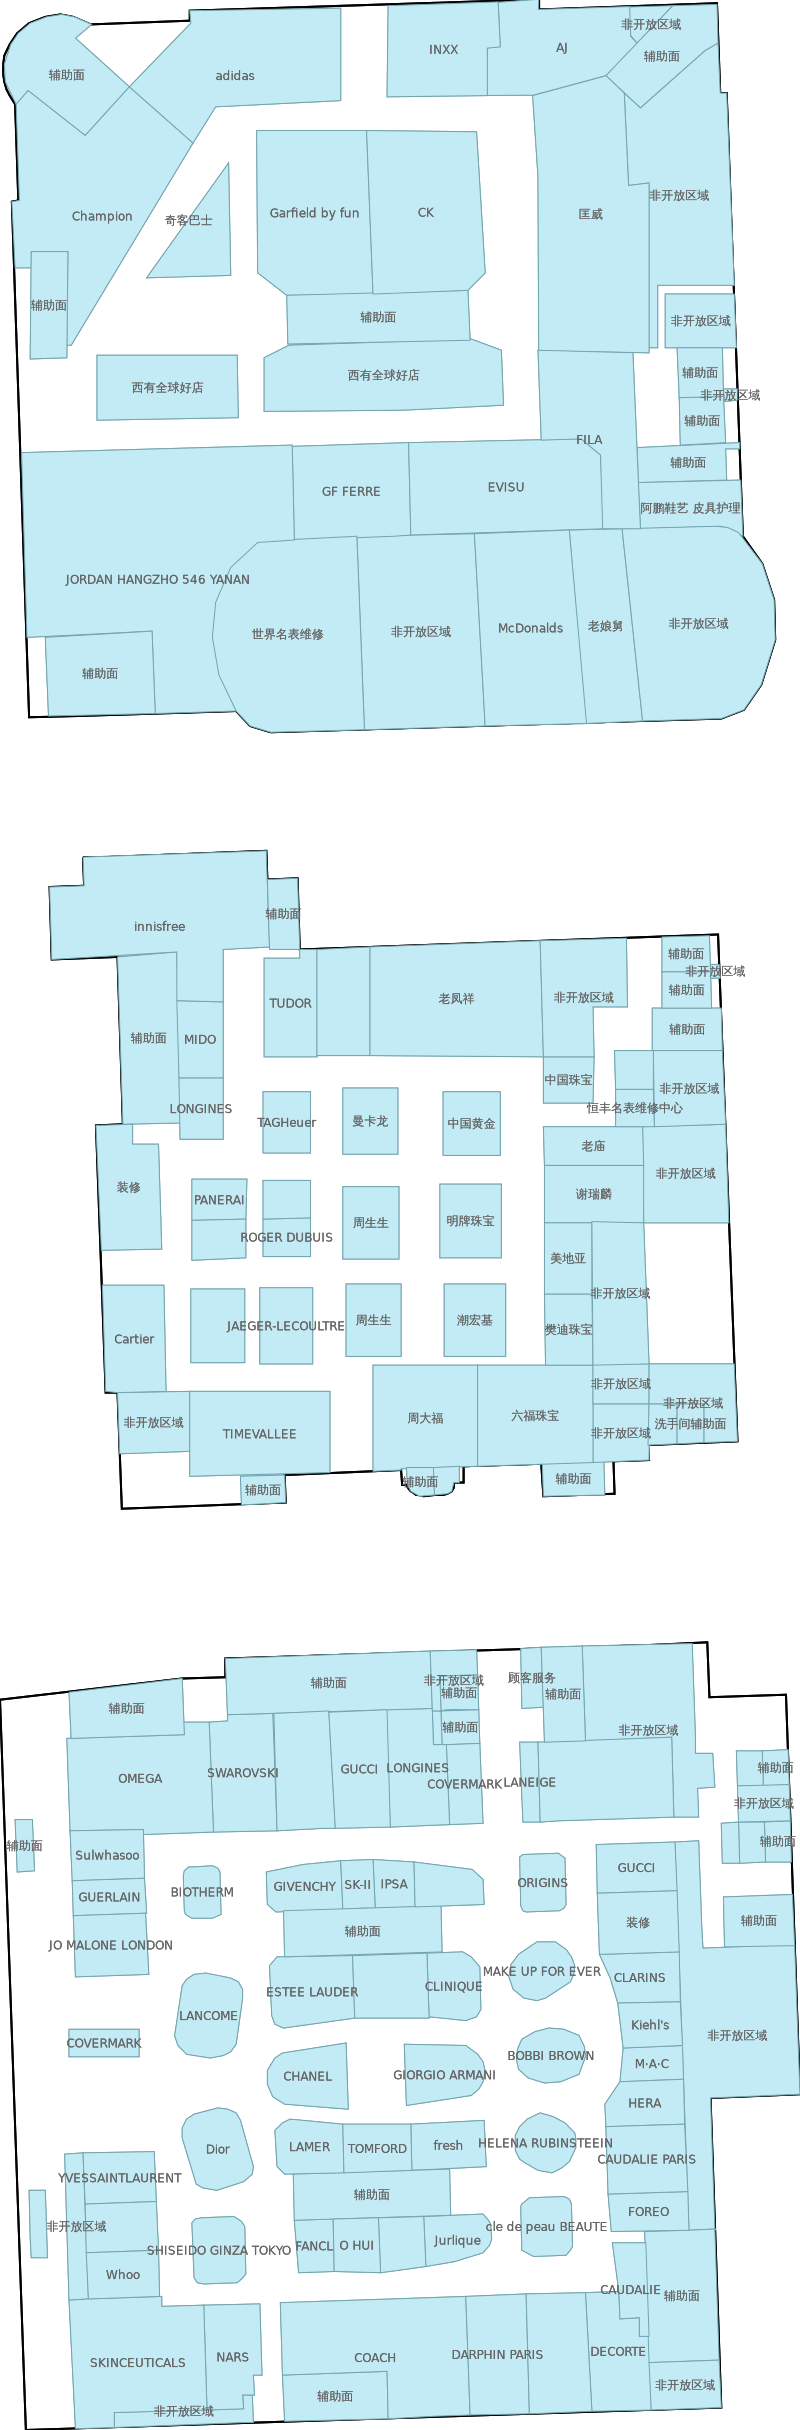

In [58]:
#################################################
# Closest Train prediction filtered

trace = np.random.choice(list(dict_val_predictions_positions.keys())) #'5d03947de99446000843c202' #
site, floor = dict_site_floor_traces[trace] #'5cd56c18e2acfd2d33b6c321', 'L2'

# trace = '5d03947de99446000843c202'
# site, floor = '5cd56c18e2acfd2d33b6c321', 'L2'

plotTrajectory(site, floor, 
               y_true=dict_train_true_positions[trace]['label'], 
               y_pred=dict_matched_prediction_filtered[trace]['prediction'] * 100)

#################################################

In [36]:
#################################################
# Metrics And Score

# dict_train_true_positions[trace]['label']
# dict_val_predictions_positions_matched[trace]['prediction']
# dict_val_predictions_positions[trace]

list_site, list_floor, list_trace = [], [], []
list_x_true, list_y_true, list_x_pred_raw, list_y_pred_raw = [], [], [], []
list_x_pred_matched, list_y_pred_matched = [], []
list_x_pred_matched_thresh, list_y_pred_matched_thresh = [], []

for trace in tqdm(dict_val_predictions_positions_matched):
    site, floor = dict_val_predictions_positions_matched[trace]['site'], dict_val_predictions_positions_matched[trace]['floor']
    num_w = dict_train_true_positions[trace]['label'].shape[0]
    list_site.extend([site for i in range(num_w)])    
    list_floor.extend([floor for i in range(num_w)])    
    list_trace.extend([trace for i in range(num_w)])    
    list_x_true.extend(dict_train_true_positions[trace]['label'][:, 0] / 100.)
    list_y_true.extend(dict_train_true_positions[trace]['label'][:, 1] / 100.)
    list_x_pred_raw.extend(dict_val_predictions_positions[trace]['predictions'][:, 0])
    list_y_pred_raw.extend(dict_val_predictions_positions[trace]['predictions'][:, 1])
    list_x_pred_matched.extend(dict_val_predictions_positions_matched[trace]['prediction'][:, 0])
    list_y_pred_matched.extend(dict_val_predictions_positions_matched[trace]['prediction'][:, 1])
    list_x_pred_matched_thresh.extend(dict_matched_prediction_filtered[trace]['prediction'][:, 0])
    list_y_pred_matched_thresh.extend(dict_matched_prediction_filtered[trace]['prediction'][:, 1])
    
num_preds = 1000 #len(list_x_pred_raw)
df_score = pd.DataFrame({
    'site' : list_site[:num_preds],
    'floor' : list_floor[:num_preds],
    'trace' : list_trace[:num_preds],
    'x_true' : list_x_true[:num_preds],
    'y_true' : list_y_true[:num_preds],
    'x_pred_raw' : list_x_pred_raw[:num_preds],
    'y_pred_raw' : list_y_pred_raw[:num_preds],
    'x_pred_matched' : list_x_pred_matched[:num_preds],
    'y_pred_matched' : list_y_pred_matched[:num_preds],
    'x_pred_matched_tresh' : list_x_pred_matched_thresh[:num_preds],
    'y_pred_matched_tresh' : list_y_pred_matched_thresh[:num_preds]
})

diff_x_raw = np.power((df_score['x_true'] * 100 - df_score['x_pred_raw'] * 100), 2)
diff_y_raw = np.power((df_score['y_true'] * 100 - df_score['y_pred_raw'] * 100), 2)

diff_x_matched = np.power((df_score['x_true'] * 100 - df_score['x_pred_matched'] * 100), 2)
diff_y_matched = np.power((df_score['y_true'] * 100 - df_score['y_pred_matched'] * 100), 2)

diff_x_matched_tresh = np.power((df_score['x_true'] * 100 - df_score['x_pred_matched_tresh'] * 100), 2)
diff_y_matched_tresh = np.power((df_score['y_true'] * 100 - df_score['y_pred_matched_tresh'] * 100), 2)

metric_raw = np.sqrt(diff_x_raw + diff_y_raw)
metric_matched = np.sqrt(diff_x_matched + diff_y_matched)
metric_matched_thresh = np.sqrt(diff_x_matched_tresh + diff_y_matched_tresh)

print(metric_raw.mean())
print(metric_matched.mean())
print(metric_matched_thresh.mean())

# 8.4
# Raw - 9.51
# Matched - 8.69
# Matched Thresh - 8.79 (t=15)

# 8.5
# Raw - 8.4
# Matched - 7.32
# Matched Thresh - 7.41 (t=15)
    
#################################################


8.456955643944738
7.639938890674344
7.659010517075416
